# LCG-based random number generator

Implement an LCG-based random number generator for uniform random numbers and experiment with different values for $a, c, M$.

In [1]:
import itertools

def lcg(x_i, a, c, M):
    while True:
        x_i = (a * x_i + c) % M
        yield x_i/M
        
lcg_generator = lcg(0, 135412, 5121, 1712289)
take = lambda f, n: list(itertools.islice(f, n))

In [2]:
import random
import numpy as np

n = 500

%time lcg_uniform    = take(lcg_generator, n)
%time python_uniform = [random.uniform(0, 1) for _ in range(n)]
%time numpy_uniform  = np.random.uniform(0, 1, n)

CPU times: user 140 µs, sys: 3 µs, total: 143 µs
Wall time: 145 µs
CPU times: user 229 µs, sys: 7 µs, total: 236 µs
Wall time: 239 µs
CPU times: user 34 µs, sys: 11 µs, total: 45 µs
Wall time: 47 µs


## Speed test

Time to generate 10000 numbers.

* LCG iterative:   3.7 ms
* Python random:   5.67 ms
* Numpy random:  0.485 ms

Taking LCG as a baseline then

* Python random: 0.65 times faster
* Numpy random:  7.6 times faster

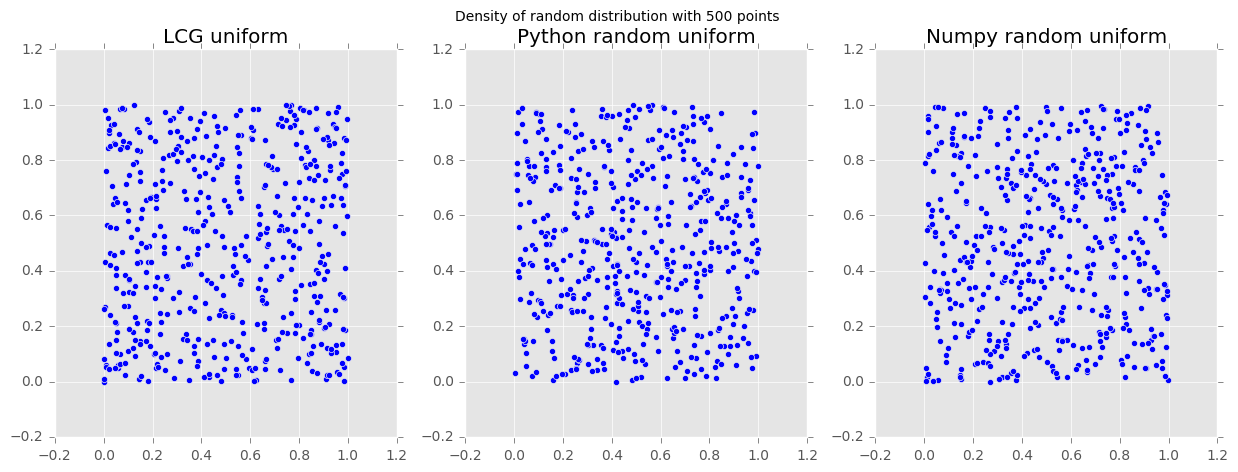

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("ggplot")

def right_shift(x):
    return [0] + list(x)[:-1]

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

ax1.scatter(lcg_uniform, right_shift(lcg_uniform))
ax1.set_title("LCG uniform")

ax2.scatter(python_uniform, right_shift(python_uniform))
ax2.set_title("Python random uniform")

ax3.scatter(numpy_uniform, right_shift(numpy_uniform))
ax3.set_title("Numpy random uniform")

f.suptitle("Density of random distribution with {} points".format(n))

plt.show()

# Tests for distribution

Apply different statistical tests to the generator.

We do a Kolmogorov-Smirnov test along with a $\chi^2$ test on the empirical data.

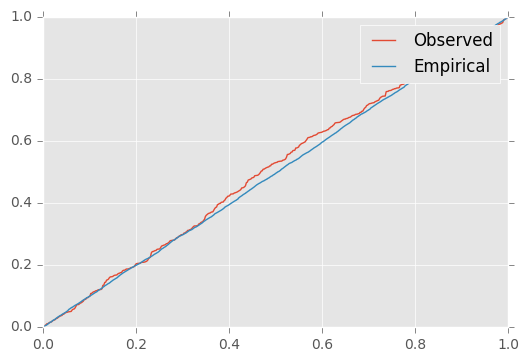

In [5]:
x = take(lcg_generator, n)
a, = plt.plot(1.0*np.arange(len(x))/(len(x) - 1), np.sort(x))

y = np.random.uniform(0, 1, 10000)
b, = plt.plot(1.0*np.arange(len(y))/(len(y) - 1), np.sort(y))

plt.legend([a, b], ["Observed", "Empirical"])

plt.show()

In [11]:
def ks(x):
    n = m = len(x)
    D = np.max(np.sort(x) - np.sort(np.random.uniform(0, 1, m)))
    c = 1.36 # c(alpha) value for p = 0.05
    value = c * np.sqrt((n+m)/n*m)

    # if True then reject
    return D > value

ks(x)

False

In [12]:
from scipy.stats import kstest
kstest(np.random.uniform(0, 1, 10000), 'uniform')

KstestResult(statistic=0.0045781891054204604, pvalue=0.9847900829277173)

We accept the null hypothesis because p > 0.05 therefore, this is a uniform distribution.

In [13]:
def chisquare(x, y):
    x = np.sort(x)
    y = np.sort(y)
    return sum((x - y)**2/x)

# Tests for independence

We use Knuth's up/down test to determine independence.

In [54]:
def up_down(x):
    n = len(x)
    
    def count_occurences(x):
        n = len(x)        
        inf = 99999999
        y = x.copy() + [-inf]

        count = 1
        for i in range(n):
            if y[i+1] < y[i]:
                yield count
                count = 0
            count += 1


    A = np.array([
              [ 4529.4,  9044.9, 13568,  18091,  22615,  27892],
              [ 9044.9, 18097,   27139,  36187,  45234,  55789],
              [13568,   27139,   40721,  54281,  67852,  83685],
              [18091,   36187,   54281,  72414,  90470, 111580],
              [22615,   45234,   67852,  90470, 113262, 139476],
              [27892,   55789,   83685, 111580, 139476, 172860]])

    B = np.array([1/6, 5/24, 11/120, 19/720, 29/5040, 1/840])

    occurences = list(count_occurences(x))
    
    R =  [sum(filter(lambda x: x == i, occurences)) for i in range(1, 6)]
    R += [sum(filter(lambda x: x >= 6, occurences))]

    Z = 1/(n - 6) * (R - n*B).T @ A @ (R - n*B)
        
    return R, Z

In [55]:
R, Z = up_down(take(lcg_generator, 10000))